In [1]:
import numpy
import json
import requests

Client identification

In [2]:
client_json = json.load(open("client_secret.txt", "r"))
client_secret = client_json["client_secret"]
client_id = client_json["client_id"]

Athlete connection

In [3]:
login_url = f"""http://www.strava.com/oauth/authorize?client_id={client_id}&response_type=code&redirect_uri=http://localhost/exchange_token&approval_prompt=force&scope=activity:read_all"""
print(login_url)

http://www.strava.com/oauth/authorize?client_id=73454&response_type=code&redirect_uri=http://localhost/exchange_token&approval_prompt=force&scope=activity:read_all


In [4]:
# Insert code from URL here
code = ""

Token exchange

In [5]:
r = requests.post('https://www.strava.com/api/v3/oauth/token', data={'key' : 'value',
                                                                    'client_id' : client_id,
                                                                    'client_secret' : client_secret,
                                                                    'code' : code,
                                                                    'grant_type' : 'authorization_code'})

In [6]:
assert 200 == r.status_code

In [7]:
response = json.loads(r.text)

In [8]:
access_token = response["access_token"]

Cache requests

In [9]:
import os
import hashlib

In [10]:
def hash_hex(query):
    sha = hashlib.sha256()
    sha.update(query.encode())
    return sha.hexdigest()[:10]

In [11]:
def request_cache(query, verbose=False, overwrite=False):
    if verbose:print("Query is:", query)
    query_hash = hash_hex(query)
    query_path = os.path.join("query_cache", str(query_hash))
    if verbose:
        print("Cache path is:", query_path)
    
    if not overwrite:
        if os.path.exists(query_path):
            if verbose:print("Exists")
            return json.load(open(query_path, "r"))

    if verbose:print("Does not exist. Querying & saving.")
    r = requests.get(query, headers = {'Content-Type':'application/json',
                                       "Authorization" : f"Bearer {access_token}"})

    if r.status_code == 200:
        result = json.loads(r.text)
        json.dump(result, open(query_path, "w"))
        return result
    else:
        print(f"Error with query {query}, returned {r.text}")
        raise ValueError

List all activities

In [12]:
all_activities = []
limit = 20
for i in range(1, limit + 1):
    print(i)
    query = f"https://www.strava.com/api/v3/athlete/activities?page={i}&per_page=30"
    activities_sub = request_cache(query, True, True)
    print(len(activities_sub))
    if len(activities_sub) == 0:
        break
        
    all_activities.extend(activities_sub)

1
Query is: https://www.strava.com/api/v3/athlete/activities?page=1&per_page=30
Cache path is: query_cache/fdc2f0b2cb
Does not exist. Querying & saving.
30
2
Query is: https://www.strava.com/api/v3/athlete/activities?page=2&per_page=30
Cache path is: query_cache/5551a27396
Does not exist. Querying & saving.
30
3
Query is: https://www.strava.com/api/v3/athlete/activities?page=3&per_page=30
Cache path is: query_cache/0f00c29f19
Does not exist. Querying & saving.
30
4
Query is: https://www.strava.com/api/v3/athlete/activities?page=4&per_page=30
Cache path is: query_cache/0f502fa52e
Does not exist. Querying & saving.
30
5
Query is: https://www.strava.com/api/v3/athlete/activities?page=5&per_page=30
Cache path is: query_cache/b3ec885450
Does not exist. Querying & saving.
30
6
Query is: https://www.strava.com/api/v3/athlete/activities?page=6&per_page=30
Cache path is: query_cache/57843ff1cb
Does not exist. Querying & saving.
30
7
Query is: https://www.strava.com/api/v3/athlete/activities?pag

Cache in all activities details

In [13]:
from tqdm.notebook import tqdm

In [14]:
all_activities_fine = []
for activity in tqdm(all_activities):
    activity_id = activity["id"]
    activity_fine = request_cache(f"https://www.strava.com/api/v3/activities/{activity_id}")
    all_activities_fine.append(activity_fine)

  0%|          | 0/228 [00:00<?, ?it/s]

In [15]:
all_activities_fine = [x for x in all_activities_fine if x["type"] == "Run"]

In [16]:
len(all_activities_fine)

175

Explore activity

In [17]:
activity_fine = all_activities_fine[0]

Utils

In [19]:
import matplotlib.pyplot as plt

In [20]:
def pace_activity_spkm(activity_fine):
    speed_mps = activity_fine["distance"] / activity_fine["moving_time"]
    pace_spm = 1 / speed_mps
    pace_spkm = pace_spm * 1000
    return pace_spkm
    # get_min_sec_fromseconds(pace_spkm)

In [21]:
def speed_activity_kmh(activity_fine):
    speed_mps = activity_fine["distance"] / activity_fine["moving_time"]
    speed_kmh = speed_mps * 3.6
    return speed_kmh
    # get_min_sec_fromseconds(pace_spkm)

In [22]:
def get_min_sec_fromseconds(seconds):
    mins = int(seconds / 60)
    seconds_remainder = int(seconds % 60)
    return mins, seconds_remainder

Plot perfs

In [23]:
all_paces_spkm = [pace_activity_spkm(x) for x in all_activities_fine]
all_speeds_kmh = [speed_activity_kmh(x) for x in all_activities_fine]
all_paces_minpkm = [pace_activity_spkm(x) / 60 for x in all_activities_fine]
all_distances_km = [x["distance"] / 1e3 for x in all_activities_fine]

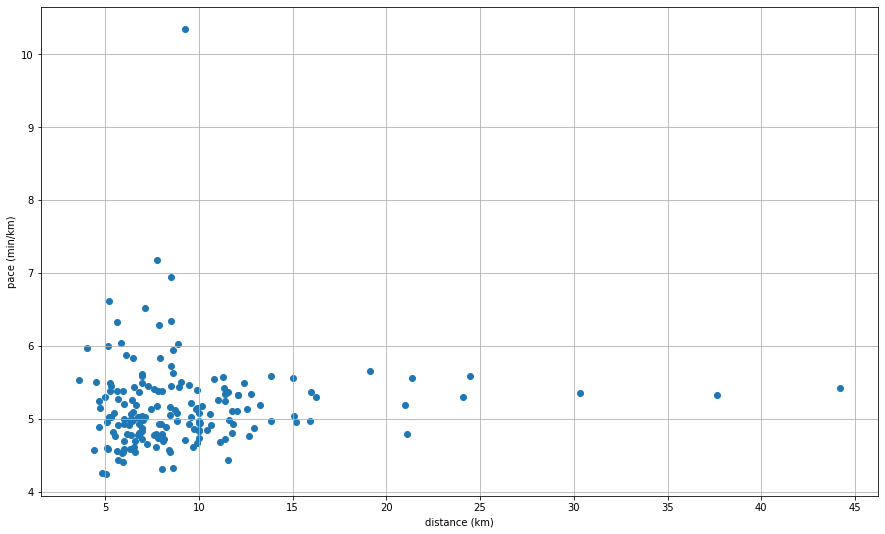

In [24]:
plt.figure(figsize=[15,9])
plt.scatter(all_distances_km, all_paces_minpkm)
plt.ylabel("pace (min/km)")
plt.xlabel("distance (km)")
plt.grid()
plt.show()

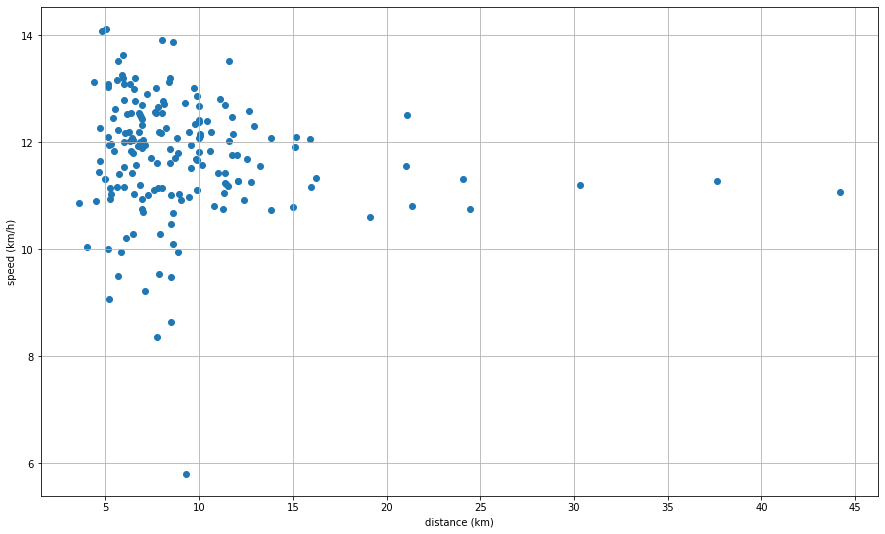

In [25]:
plt.figure(figsize=[15,9])
plt.scatter(all_distances_km, all_speeds_kmh)
plt.ylabel("speed (km/h)")
plt.xlabel("distance (km)")
plt.grid()
plt.show()

Breakdown activities

In [26]:
def extract_sub_activities(activities_fine):
    all_sub_activities_fine = []
    for activity_fine in activities_fine:
        if "id" not in activity_fine:
            print(activity_fine)
        if "splits_metric" in activity_fine:
            splits = activity_fine["splits_metric"]
            for splits_slice in iterate_splits(splits):
                distance, moving_time = combine_splits(splits_slice)
                all_sub_activities_fine.append({"distance" : distance,
                                                "moving_time" : moving_time,
                                                "source_id" : activity_fine["id"]})
        else:
            # These runs are manually entered ones
            # print("splits not found for ", activity_fine["id"])
            all_sub_activities_fine.append({"distance" : activity_fine["distance"],
                                            "moving_time" : activity_fine["moving_time"],
                                            "source_id" : activity_fine["id"]})

    return all_sub_activities_fine

In [27]:
def combine_splits(splits_slice):
    distance = sum([x["distance"] for x in splits_slice])
    moving_time = sum([x["moving_time"] for x in splits_slice])
    return distance, moving_time

In [28]:
def iterate_splits(splits):
    for i in range(len(splits)):
        for j in range(i):
            yield splits[j:i]

In [29]:
all_sub_activities_fine = extract_sub_activities(all_activities_fine)

Plot for all sub splits

In [30]:
all_paces_spkm = [pace_activity_spkm(x) for x in all_sub_activities_fine]
all_speeds_kmh = [speed_activity_kmh(x) for x in all_sub_activities_fine]
all_paces_minpkm = [pace_activity_spkm(x) / 60 for x in all_sub_activities_fine]
all_distances_km = [x["distance"] / 1e3 for x in all_sub_activities_fine]

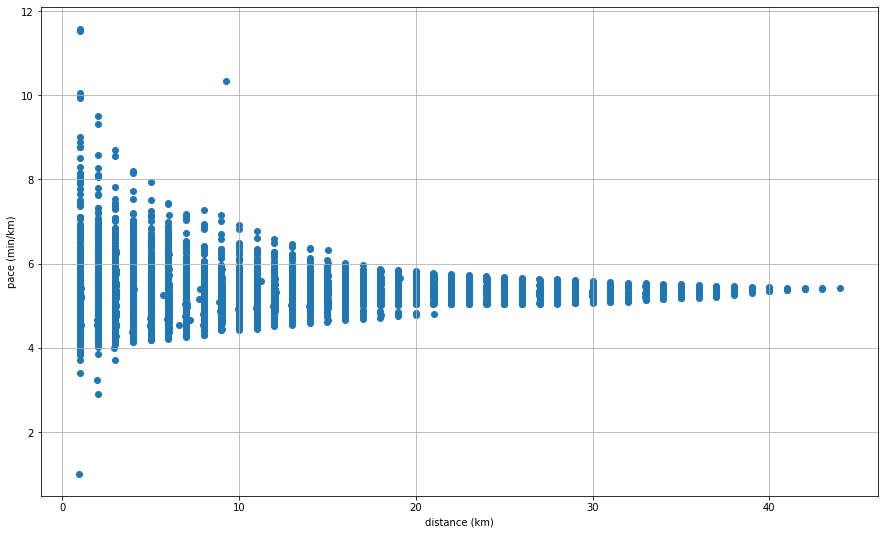

In [31]:
plt.figure(figsize=[15,9])
plt.scatter(all_distances_km, all_paces_minpkm)
plt.ylabel("pace (min/km)")
plt.xlabel("distance (km)")
plt.grid()
plt.show()

Cover curve by slice of runs

In [32]:
import pandas as pd
import numpy as np

In [33]:
def extract_cover(sub_activities_fine):
    df = pd.DataFrame(sub_activities_fine)
    # Distances are 1k +- 5%, need to round & group
    distance_round = df.distance
    distance_round = np.round(distance_round / 1e3, 0)
    
    df["distance_km_round"] = distance_round
    df["speed_mps"] = df["distance"] / df["moving_time"]
    df["speed_kmh"] = df["speed_mps"] * 3.6
    df["speed_kmh"] = np.minimum(df["speed_kmh"], 20)
    return df.groupby("distance_km_round").speed_kmh.max()

In [34]:
class ActivitiesSplitter():
    def __init__(self):
        pass
    
    def split(self, activities):
        raise NotImplementedError
    
class CountActivitiesSplitter():
    def __init__(self, bucket_size):
        self.bucket_size = bucket_size
        
    def split(self, activities):
        num_splits = int(np.ceil(len(activities) / self.bucket_size))
        splits = []
        for k in range(num_splits):
            sub_activities = activities[k*self.bucket_size:(k+1)*self.bucket_size]
            splits.append(sub_activities)
            
        # If last batch has less than 5 activities, merge with previous
        if len(splits[-1]) < 5:
            splits = splits[:-2] + [splits[-1] + splits[-2]]
            
        for sub_activity_slice in splits:
            yield sub_activity_slice

cas = CountActivitiesSplitter(bucket_size=30)
L = 0
for sub_activities in cas.split(all_activities_fine):
    L += len(sub_activities)
assert L == len(all_activities_fine)



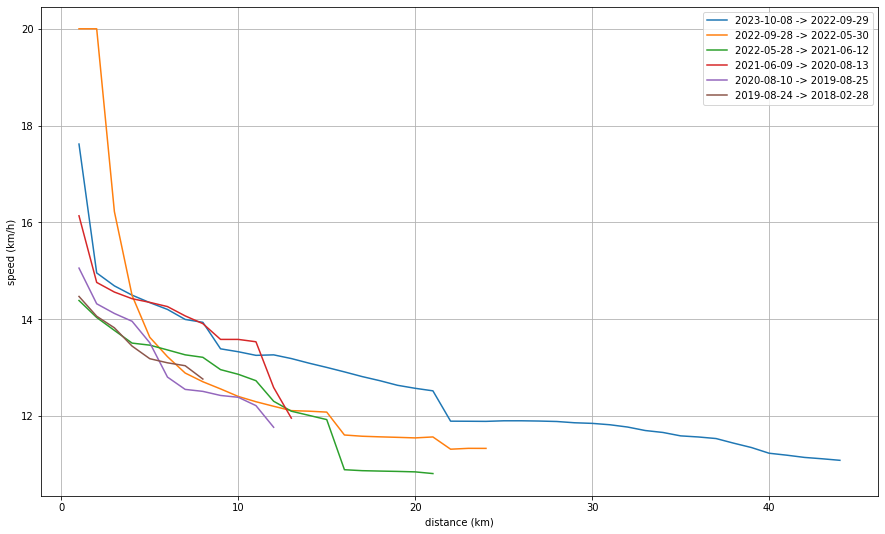

In [35]:
plt.figure(figsize=[15, 9])
for sub_activities in cas.split(all_activities_fine):
    all_sub_activities_fine = extract_sub_activities(sub_activities)
    cover = extract_cover(all_sub_activities_fine)
    
    label = sub_activities[0]["start_date_local"][:10] + " -> " + sub_activities[-1]["start_date_local"][:10]
    plt.plot(cover, label = label)

plt.legend()
plt.ylabel("speed (km/h)")
plt.xlabel("distance (km)")
plt.grid()
plt.show()

In [38]:
cas = CountActivitiesSplitter(bucket_size=15)
L = 0
for sub_activities in cas.split(all_activities_fine):
    L += len(sub_activities)
assert L == len(all_activities_fine)

target_distances = [2, 5, 10, 15, 20]
recs = []
for sub_activities in cas.split(all_activities_fine):
    rec = {}
    label = sub_activities[0]["start_date_local"][:10] + " -> " + sub_activities[-1]["start_date_local"][:10]
    rec["label"] = label
    for target_distance in target_distances:
        all_sub_activities_fine = extract_sub_activities(sub_activities)
        cover = extract_cover(all_sub_activities_fine)
        try:
            speed = cover[target_distance]
            rec[f"top_speed_at_{target_distance}"] = speed
        except KeyError as e:
            pass
        
    recs.append(rec)
        
plt.figure(figsize=[15, 9])
pd.DataFrame(recs).set_index("label").round(1)

,top_speed_at_2,top_speed_at_5,top_speed_at_10,top_speed_at_15,top_speed_at_20
label,,,,,
2023-10-08 -> 2023-01-28,15.0,14.3,11.3,NaN,NaN
2022-11-06 -> 2022-09-29,14.7,13.7,13.3,13.0,12.6
2022-09-28 -> 2022-09-06,20.0,13.6,12.4,12.1,11.5
2022-09-01 -> 2022-05-30,13.3,13.0,12.1,11.2,NaN
2022-05-28 -> 2021-12-04,13.6,13.5,12.9,11.2,10.8
2021-11-17 -> 2021-06-12,14.0,13.5,12.8,11.9,NaN
2021-06-09 -> 2020-12-21,14.3,13.4,12.9,NaN,NaN
2020-12-16 -> 2020-08-13,14.8,14.3,13.6,NaN,NaN
2020-08-10 -> 2020-04-05,14.3,13.5,12.4,NaN,NaN


<Figure size 1080x648 with 0 Axes>

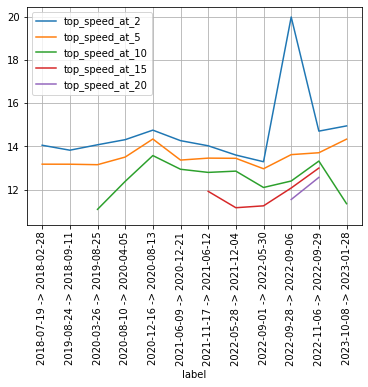

In [39]:
table = pd.DataFrame(recs).set_index("label").sort_index()
table.plot()
plt.xticks(range(len(table)), table.index, rotation=90)
plt.grid()

### Modeling

There is a raw power function $F(t)$ which is stable

It translated into a realized performance with 

$speed_i = curve(F(t), distance_i) - r_i$

$r_i$ being the drag on a given run vs. best level.

We have to jointly estimate $curve$ and $F$. 

We can add extra assumptions
- $speed$ is a decreasing function
- $F(t)$ is a continuous function, we can penalize its variation
- $r_i$ is $N(0, \sigma)$

In [104]:
sigma = 0.2

In [105]:
def C0(f, x):
    return f * (16 - 5 * x / 25)

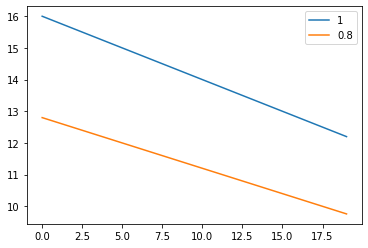

In [106]:
xs = range(20)
plt.plot(xs, [C0(1, x) for x in xs], label="1")
plt.plot(xs, [C0(.8, x) for x in xs], label="0.8")
plt.legend()

Then to find F based on the data and the current curve function, 

##### Other simpler approach
This is a regression per data point, with a strong regularization on consecutive thetas

$Y = X^T I \beta$ ?

$L = (Y - X\beta)^2 + \sum_i (\beta_i - \beta_{i-1})^2 \alpha$

With $Y$ being the speed, $X$ being the distance, $\beta$ being the current shape

In [107]:
n = 5
betas = np.array([[1],[2],[3],[7],[6]])
betas

array([[1],
       [2],
       [3],
       [7],
       [6]])

In [108]:
import numpy as np
D = np.diag([-1] * (n-1), 1)
D2 = D[:-1, :]
U = np.diag([1]*n)[:-1, :]
TR = D2+U

In [109]:
shifts = (D2 + U) @ betas

In [110]:
shifts

array([[-1],
       [-1],
       [-4],
       [ 1]])

$$
L = \sum(Y_i - \beta_iX_i)^2 + \sum\alpha(\beta_i - \beta_{i-1})^2
$$

$$
L = -\sum 2Y_i\beta_iX_i + (\beta_iX_i)^2 + \sum\alpha(\beta_i - \beta_{i-1})^2
$$

$$
L = -2(Y*X)^T\beta + \beta^TDiag(X_i^2)\beta + \alpha\beta^TTR^TTR\beta
$$

$$ \nabla L = -2(Y*X) + 2 Diag(X_i^2)\beta + 2 \alpha TR^TTR\beta
$$

$$ \beta = (Diag(X_i^2) + \alpha TR^TTR)^{-1}(Y*X)
$$

In [111]:
all_sub_activities_fine = extract_sub_activities(all_activities_fine)

In [112]:
all_speeds_kmh = [speed_activity_kmh(x) for x in all_sub_activities_fine]
all_distances_km = [x["distance"] / 1e3 for x in all_sub_activities_fine]

In [113]:
N = 100
X = np.reshape(all_distances_km[:N], [-1, 1])
Y = np.reshape(all_speeds_kmh[:N], [-1, 1])
n = len(all_speeds_kmh[:N])

In [114]:
D = np.diag([-1] * (n-1), 1)
D2 = D[:-1, :]
U = np.diag([1]*n)[:-1, :]
TR = D2+U

In [115]:
alpha = 20

In [116]:
M = np.diag((X*X)[:, 0]) + alpha * TR.T@TR

In [117]:
betas, _, _, _ = np.linalg.lstsq(M, Y*X)

<ipython-input-117-e6beba89f05d>:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  betas, _, _, _ = np.linalg.lstsq(M, Y*X)


In [118]:
assert betas == betas0

NameError: name 'betas0' is not defined

In [119]:
betas0 = betas

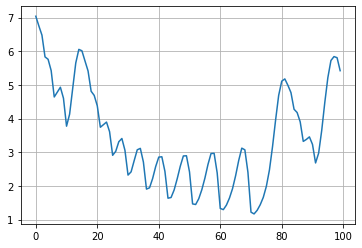

In [120]:
plt.plot(betas)
plt.grid()

In [121]:
all_betas = betas[:, 0]